In [1]:
import gymnasium as gym
import aero_gym
from stable_baselines3.common.env_checker import check_env
from gymnasium.wrappers import FrameStack, FlattenObservation, RescaleAction
import math
import numpy as np
import stable_baselines3
from stable_baselines3 import TD3, DQN, PPO
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, VecFrameStack, VecTransposeImage
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.transforms import Affine2D
from typing import Any, Dict
from pathlib import Path
from copy import deepcopy
import json
import importlib

# from control import tf, feedback, step_response, c2d

In [2]:
import sys
sys.path.append('../aero_gym_SB3/')
import trajectory_generators

In [3]:
writedir = "policy_evaluation"
Path(writedir).mkdir(parents=True, exist_ok=True)

In [150]:
# model parameters
U = 1.0;
c = 1.0;
d = 0.0;

# signal scaling factors
alphaddot_max = 0.1;
hddot_max = 0.1;
e_max = 0.1;

# time parameters
t_max = 20
delta_t = 0.1

# episode type
h_ddot_type = h_ddot_generators.random_fourier_series

In [151]:
env_generate_h_ddot = gym.make(
    'aero_gym/wagner_jones-v0',
    t_max=t_max,
    delta_t=delta_t,
    a=-0.25,
    h_ddot_generator=h_ddot_type,
    lift_threshold=10.0);

In [152]:
class PI:
    def __init__(self, Kp, Ki, Ts):
        self.Kp = Kp
        self.Ki = Ki
        self.Ts = Ts
        self._integral_error = 0.0
    
    def predict(self, info, **kwargs):
        self._integral_error += info["previous scaled fy_error"] * self.Ts
        u = self.Kp * info["previous scaled fy_error"] + self.Ki * self._integral_error
        return [u]
    
class PrescribedAction:
    def __init__(self, alpha_ddot_prescribed):
        self.alpha_ddot_prescribed = alpha_ddot_prescribed
    
    def predict(self, info, **kwargs):
        timestep = info["time_step"]
        return [self.alpha_ddot_prescribed[timestep]]

In [153]:
class Case:
    
    valid_options = [
        'use_jones_approx', 
        'continuous_actions',
        'num_discrete_actions',
        'delta_t',
        't_max',
        'rho',
        'U',
        'c',
        'a',
        'use_jones_approx',
        'reward_type',
        'observed_alpha_is_eff',
        'observe_wake',
        'observe_h_ddot',
        'observe_previous_lift',
        'observe_body_circulation',
        'observe_pressure',
        'pressure_sensor_positions',
        'lift_termination',
        'lift_scale',
        'alpha_ddot_scale',
        'h_ddot_scale']
    
    def __init__(self, name, policy, options_dict, json_file):
        self.name = name
        self.policy = policy
        self.options_dict = options_dict
        self.stacked_frames = 1
        if json_file is not None: # add parameters from json_file to options but don't overwrite any
            with open(json_file) as jf:
                json_dict = json.load(jf)
            for k,v in json_dict.items():
                if k not in self.options_dict.keys() and k in self.valid_options:
                    self.options_dict[k] = v
        
            if "observe_pressure" in json_dict:
                if json_dict["observe_pressure"] is True:
                    self.options_dict["pressure_sensor_positions"] = np.linspace(
                        json_dict["sensor_x_min"],
                        json_dict["sensor_x_max"],
                        num=json_dict["num_sensors"] + (2 if not json_dict["include_end_sensors"] else 0)
                    )
                    if not json_dict["include_end_sensors"]:
                        self.options_dict["pressure_sensor_positions"] = self.options_dict["pressure_sensor_positions"][1:-1]
            
            if json_dict["algorithm"] == "TD3":
                self.options_dict["continuous_actions"] = True

            if "stacked_frames" in json_dict:
                self.stacked_frames = json_dict["stacked_frames"]
            
    def create_env(self, tmax, delta_t):
        env = gym.make(
            'aero_gym/wagner-v0',
            render_mode="ansi",
            t_max=t_max,
            delta_t=delta_t,
            lift_termination=False,
            **self.options_dict)
        return env

In [154]:
def no_action_policy(observation):
    return [0.0]

In [155]:
parentdir = '/u/home/b/beckers/project-sofia/unsteady_aero_RL/logs/TD3_single_environment_lift_proper_jones_001_alpha_ddot_01_h_ddot_001'

In [156]:
cases = [
    Case('no_controller', PI(0, 0, delta_t), {'continuous_actions':True, 'observe_previous_lift':True}, None),
    Case('p_controller', PI(1.71, 0, delta_t), {'continuous_actions':True, 'observe_previous_lift':True}, None),
#     Case('jones_1', TD3.load(parentdir + "/TD3_jones_1/TD3_2/best_model"), json_file = parentdir + "/TD3_jones_1/TD3_1/case_args.json"),
    Case('jones_2_TD3_8', TD3.load(parentdir + "/TD3_jones_2/TD3_8/best_model"), {}, parentdir + "/TD3_jones_2/TD3_1/case_args.json"),
#     Case('pressure_1_2_TD_5', TD3.load(parentdir + "/TD3_pressure_1_2/TD3_5/best_model"), json_file = parentdir + "/TD3_pressure_1_2/TD3_1/case_args.json"),
#     Case('pressure_1_2_TD_6', TD3.load(parentdir + "/TD3_pressure_1_2/TD3_6/best_model"), json_file = parentdir + "/TD3_pressure_1_2/TD3_1/case_args.json"),
#     Case('pressure_2_2_TD_2', TD3.load(parentdir + "/TD3_pressure_2_2/TD3_2/best_model"), {}, parentdir + "/TD3_pressure_2_2/TD3_1/case_args.json"),
#     Case('pressure_2_2_TD_3', TD3.load(parentdir + "/TD3_pressure_2_2/TD3_3/best_model"), {}, parentdir + "/TD3_pressure_2_2/TD3_1/case_args.json"),
#     Case('pressure_2_2_TD_4', TD3.load(parentdir + "/TD3_pressure_2_2/TD3_4/best_model"), {}, parentdir + "/TD3_pressure_2_2/TD3_1/case_args.json"),
    Case('pressure_2_2_TD3_11', TD3.load(parentdir + "/TD3_pressure_2_2/TD3_11/best_model"), {}, parentdir + "/TD3_pressure_2_2/TD3_1/case_args.json"),
#     Case('pressure_2_2_TD_6', TD3.load(parentdir + "/TD3_pressure_2_2/TD3_6/best_model"), {}, parentdir + "/TD3_pressure_2_2/TD3_1/case_args.json")
]

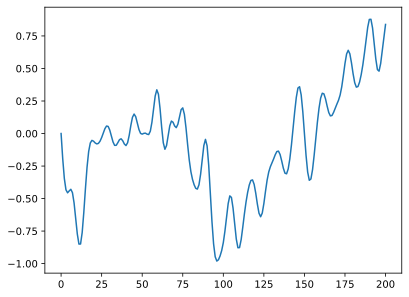

In [161]:
env_generate_h_ddot.reset()
generated_h_ddot_list = deepcopy(env_generate_h_ddot.h_ddot_list)
plt.figure()
plt.plot(generated_h_ddot_list)

In [162]:
for case in cases:
    print(case.options_dict)
    filepath = writedir + "/" + case.name + "_" + h_ddot_type.__name__ + ".txt"
    
    env = case.create_env(t_max, delta_t)
    
    if case.stacked_frames > 1:
        env = FlattenObservation(FrameStack(env, case.stacked_frames))

    writefile = open(filepath, "w")
    observation, info = env.reset(options={"h_ddot_prescribed": generated_h_ddot_list})
    done = False
    while done == False:
        writestr = env.render()
        action = case.policy.predict(observation)
        if isinstance(action, tuple):
            action = action[0]
        observation, _, terminated, truncated, info = env.step(action)
        writestr += (" {:10.3e}"*2).format(info["previous alpha_ddot"],info["previous fy"])
        writefile.write(writestr + "\n")
        done = truncated or terminated
    writefile.close()

{'continuous_actions': True, 'observe_previous_lift': True}
{'continuous_actions': True, 'observe_previous_lift': True}
{'use_jones_approx': True, 'observe_wake': True, 'observed_alpha_is_eff': True, 'observe_previous_lift': True, 'observe_pressure': False, 'lift_scale': 0.01, 'alpha_ddot_scale': 0.1, 'h_ddot_scale': 0.01, 'continuous_actions': True}
{'use_jones_approx': False, 'observe_wake': False, 'observed_alpha_is_eff': False, 'observe_previous_lift': True, 'observe_pressure': True, 'lift_scale': 0.01, 'alpha_ddot_scale': 0.1, 'h_ddot_scale': 0.01, 'pressure_sensor_positions': array([-0.16666667,  0.16666667]), 'continuous_actions': True}


policy_evaluation/no_controller_random_fourier_series.txt
policy_evaluation/p_controller_random_fourier_series.txt
policy_evaluation/jones_2_TD3_8_random_fourier_series.txt
policy_evaluation/pressure_2_2_TD3_11_random_fourier_series.txt


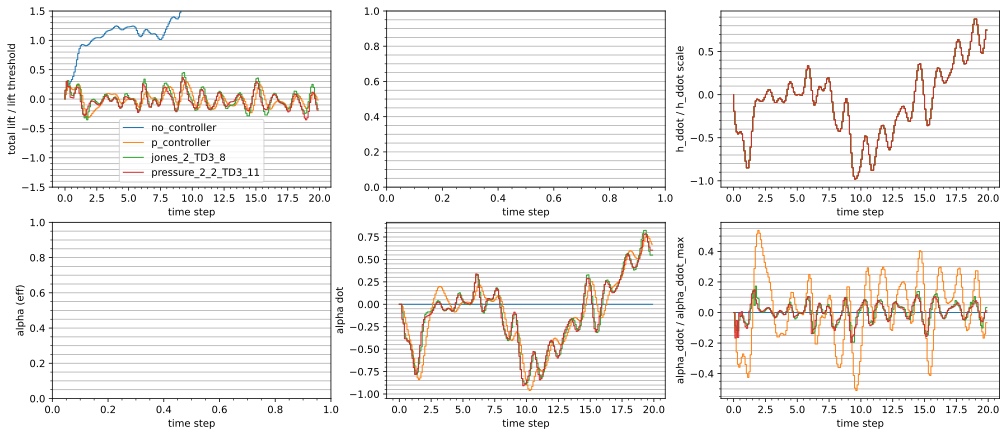

In [163]:
%config InlineBackend.figure_format = 'svg'

fig, axarr = plt.subplots(ncols=3, nrows=2, figsize=(17,7))
axarr[0,0].set_ylabel('total lift / lift threshold')
axarr[0,0].set_ylim(-1.5,1.5)
# axarr[0,1].set_ylabel('added mass lift')
axarr[0,2].set_ylabel('h_ddot / h_ddot scale')
axarr[1,0].set_ylabel('alpha (eff)')
axarr[1,1].set_ylabel('alpha dot')
axarr[1,2].set_ylabel('alpha_ddot / alpha_ddot_max')

for case in cases:
    filepath = writedir + "/" + case.name + "_" + h_ddot_type.__name__ + ".txt"
    print(filepath)
    with open(filepath, "r") as readFile:
        textstr = readFile.readlines()
        all_lines = [line.split() for line in textstr]
        t_hist = [float(x[1]) for x in all_lines]
        h_dot_list = [float(x[2]) for x in all_lines]
        alpha_list = [float(x[3]) for x in all_lines]
        alpha_dot_list = [float(x[4]) for x in all_lines]
        h_ddot_list = [float(x[5]) for x in all_lines]
        alpha_ddot_list = [float(x[6]) for x in all_lines]
        fy_hist = [float(x[7]) for x in all_lines]
#         am_list = [math.pi / 4 * (-h_ddot_list[i] - a * alpha_ddot_list[i] + alpha_dot_list[i]) for i in range(len(h_ddot_list))]
        axarr[0,0].step(t_hist,fy_hist,label=case.name, linewidth=1)
#         axarr[0,1].plot(t_hist,am_list, linewidth=1)
        axarr[0,2].step(t_hist,h_ddot_list, linewidth=1)
#         axarr[1,0].plot(t_hist,alpha_list, linewidth=1)
        axarr[1,1].step(t_hist,alpha_dot_list, linewidth=1)
        axarr[1,2].step(t_hist,alpha_ddot_list, linewidth=1)
        readFile.close()
        
axarr[0,0].legend()
for ax in axarr.flatten():
    ax.minorticks_on()
    ax.grid(which='both',axis='y')
    ax.set_xlabel('time step')


## Write to files

In [8]:
# loaded_DQN_model_quarter_chord = DQN.load("/u/home/b/beckers/project-sofia/unsteady_aero_RL/logs/DQN_reward_type_3_quarter_chord/DQN_1/saved_model")
# loaded_DQN_model_mid_chord = DQN.load("/u/home/b/beckers/project-sofia/unsteady_aero_RL/logs/DQN_reward_type_3_saved/DQN_1/saved_model")

In [9]:
# loaded_TD3_model_quarter_chord = TD3.load("/u/home/b/beckers/project-sofia/unsteady_aero_RL/logs/TD3_reward_type_3_saved_quarter_chord/TD3_1/saved_model")
# loaded_TD3_model_mid_chord = TD3.load("/u/home/b/beckers/project-sofia/unsteady_aero_RL/logs/TD3_reward_type_3_saved/TD3_1/saved_model")

In [10]:
parentdir = '/u/home/b/beckers/project-sofia/unsteady_aero_RL/logs/TD3_partial_observability_test_v3_steps_ramps_eval'
cases = [
    ('no_action', 'aero_gym/wagner_jones-v0', {'continuous_actions':True}, 1, no_action_policy),
    (
        'jones_2',
        'aero_gym/wagner_jones-v0',
        {'continuous_actions':True, 'observe_wake':True, 'observe_previous_lift':True},
        2,
        TD3.load(parentdir + "/TD3_jones_2/TD3_7/best_model").policy.predict
    ),
    (
        'pressure_10_2',
        'aero_gym/wagner-v0',
        {'continuous_actions':True, 'observe_pressure':True, 'observe_previous_lift':True, 'pressure_sensor_positions':np.linspace(-0.5,0.5,12)[1:-1]},
        2,
        TD3.load(parentdir + "/TD3_pressure_10_2/TD3_1/best_model").policy.predict
    ),
    (
        'pressure_2_2',
        'aero_gym/wagner-v0',
        {'continuous_actions':True, 'observe_pressure':True, 'observe_previous_lift':True, 'pressure_sensor_positions':np.linspace(-0.5,0.5,4)[1:-1]},
        2,
        TD3.load(parentdir + "/TD3_pressure_2_2/TD3_4/best_model").policy.predict
    ),
    (
        'pressure_1_2',
        'aero_gym/wagner-v0',
        {'continuous_actions':True, 'observe_pressure':True, 'observe_previous_lift':True, 'pressure_sensor_positions':[0.0]},
        2,
        TD3.load(parentdir + "/TD3_pressure_1_2/TD3_3/best_model").policy.predict
    ),
    (
        'no_wake_info_2',
        'aero_gym/wagner-v0',
        {'continuous_actions':True, 'observe_previous_lift':True},
        2,
        TD3.load(parentdir + "/TD3_no_wake_info_2/TD3_4/best_model").policy.predict
    ),
#     (
#         'jones_1',
#         'aero_gym/wagner_jones-v0',
#         {'continuous_actions':True, 'observe_wake':True, 'observe_previous_lift':True},
#         1,
#         TD3.load(parentdir + "/TD3_jones_1/TD3_5/best_model").policy.predict
#     ),
#     (
#         'pressure_10_1',
#         'aero_gym/wagner-v0',
#         {'continuous_actions':True, 'observe_pressure':True, 'observe_previous_lift':True, 'pressure_sensor_positions':np.linspace(-0.5,0.5,12)[1:-1]},
#         1,
#         TD3.load(parentdir + "/TD3_pressure_10_1/TD3_1/best_model").policy.predict
#     ),
#     (
#         'pressure_2_1',
#         'aero_gym/wagner-v0',
#         {'continuous_actions':True, 'observe_pressure':True, 'observe_previous_lift':True, 'pressure_sensor_positions':np.linspace(-0.5,0.5,4)[1:-1]},
#         1,
#         TD3.load(parentdir + "/TD3_pressure_2_1/TD3_4/best_model").policy.predict
#     ),
#     (
#         'pressure_1_1',
#         'aero_gym/wagner-v0',
#         {'continuous_actions':True, 'observe_pressure':True, 'observe_previous_lift':True, 'pressure_sensor_positions':[0.0]},
#         1,
#         TD3.load(parentdir + "/TD3_pressure_1_1/TD3_4/best_model").policy.predict
#     ),
#     (
#         'no_wake_info_1',
#         'aero_gym/wagner-v0',
#         {'continuous_actions':True, 'observe_previous_lift':True},
#         1,
#         TD3.load(parentdir + "/TD3_no_wake_info_1/TD3_1/best_model").policy.predict
#     ),
#     (
#         'circulation_10',
#         'aero_gym/wagner-v0',
#         {'continuous_actions':True, 'observe_previous_lift':True, 'observe_body_circulation':True},
#         10,
#         TD3.load(parentdir + "/TD3_circulation_10/TD3_1/best_model").policy.predict
#     ),
    
#     (False, 0.0, loaded_DQN_model_mid_chord.policy.predict, "DQN_mid_chord"),
#     (False, -0.25, loaded_DQN_model_quarter_chord.policy.predict, "DQN_quarter_chord"),
#     (True, 0.0, loaded_TD3_model_mid_chord.policy.predict, "TD3_mid_chord"),
#     (True, -0.25, loaded_TD3_model_quarter_chord.policy.predict, "TD3_quarter_chord"),
#     (True, 0.0, no_action_policy, "no_action"),
#     (True, 0.0, am_action_mid_chord_policy, "am_action_mid_chord"),
#     (True, -0.25, am_action_quarter_chord_policy,"am_action_quarter_chord"),
#     (True, -0.25, am_action_quarter_chord_policy_2,"am_action_quarter_chord_2"),
]

Take a h_ddot_list to use in all environments

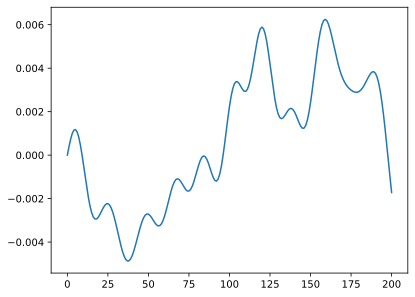

In [17]:
env_generate_h_ddot.reset()
generated_h_ddot_list = deepcopy(env_generate_h_ddot.h_ddot_list)
plt.figure()
plt.plot(generated_h_ddot_list)

In [18]:
for case in cases:
    print(case.options)
    filepath = writedir + "/" + case.name + "_" + h_ddot_type.__name__ + ".txt"
    
    env = gym.make(
        environment_name,
        render_mode="ansi",
        t_max=t_max,
        delta_t=delta_t,
        lift_threshold=10.0,
        **kwargs)
    
    if frames > 1:
        env = FlattenObservation(FrameStack(env, frames))
    
    writefile = open(filepath, "w")
    observation, info = env.reset(options={"h_ddot_prescribed": generated_h_ddot_list})
    done = False
    while done == False:
        writestr = env.render()
        action = policy(observation)
        if isinstance(action, tuple):
            action = action[0]
        observation, _, terminated, truncated, info = env.step(action)
        writestr += (" {:10.3e}"*2).format(info["previous alpha_ddot"],info["previous fy"])
        writefile.write(writestr + "\n")
        done = truncated or terminated
    writefile.close()

{'continuous_actions': True}
{'continuous_actions': True, 'observe_wake': True, 'observe_previous_lift': True}
{'continuous_actions': True, 'observe_pressure': True, 'observe_previous_lift': True, 'pressure_sensor_positions': array([-0.40909091, -0.31818182, -0.22727273, -0.13636364, -0.04545455,
        0.04545455,  0.13636364,  0.22727273,  0.31818182,  0.40909091])}
{'continuous_actions': True, 'observe_pressure': True, 'observe_previous_lift': True, 'pressure_sensor_positions': array([-0.16666667,  0.16666667])}
{'continuous_actions': True, 'observe_pressure': True, 'observe_previous_lift': True, 'pressure_sensor_positions': [0.0]}
{'continuous_actions': True, 'observe_previous_lift': True}


policy_evaluation/no_action_random_fourier_series.txt
policy_evaluation/jones_2_random_fourier_series.txt
policy_evaluation/pressure_10_2_random_fourier_series.txt
policy_evaluation/pressure_2_2_random_fourier_series.txt
policy_evaluation/pressure_1_2_random_fourier_series.txt
policy_evaluation/no_wake_info_2_random_fourier_series.txt


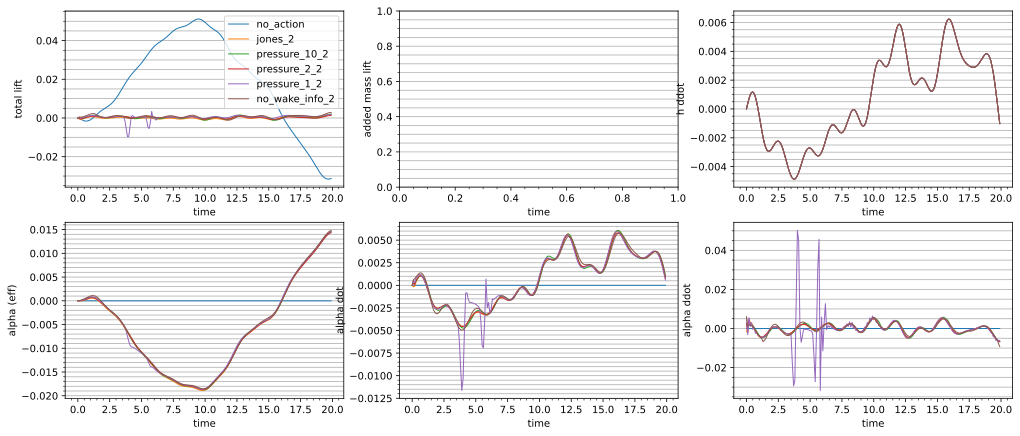

In [19]:
%config InlineBackend.figure_format = 'svg'

fig, axarr = plt.subplots(ncols=3, nrows=2, figsize=(17,7))
axarr[0,0].set_ylabel('total lift')
axarr[0,1].set_ylabel('added mass lift')
axarr[0,2].set_ylabel('h ddot')
axarr[1,0].set_ylabel('alpha (eff)')
axarr[1,1].set_ylabel('alpha dot')
axarr[1,2].set_ylabel('alpha ddot')

for name, environment_name, kwargs, frames, policy in cases:
    filepath = writedir + "/" + name + "_" + h_ddot_type.__name__ + ".txt"
    print(filepath)
    with open(filepath, "r") as readFile:
        textstr = readFile.readlines()
        all_lines = [line.split() for line in textstr]
        t_hist = [float(x[1]) for x in all_lines]
        h_dot_list = [float(x[2]) for x in all_lines]
        alpha_list = [float(x[3]) for x in all_lines]
        alpha_dot_list = [float(x[4]) for x in all_lines]
        h_ddot_list = [float(x[5]) for x in all_lines]
        alpha_ddot_list = [float(x[6]) for x in all_lines]
        fy_hist = [float(x[7]) for x in all_lines]
#         am_list = [math.pi / 4 * (-h_ddot_list[i] - a * alpha_ddot_list[i] + alpha_dot_list[i]) for i in range(len(h_ddot_list))]
        axarr[0,0].plot(t_hist,fy_hist,label=name, linewidth=1)
#         axarr[0,1].plot(t_hist,am_list, linewidth=1)
        axarr[0,2].plot(t_hist,h_ddot_list, linewidth=1)
        axarr[1,0].plot(t_hist,alpha_list, linewidth=1)
        axarr[1,1].plot(t_hist,alpha_dot_list, linewidth=1)
        axarr[1,2].plot(t_hist,alpha_ddot_list, linewidth=1)
        readFile.close()
        
axarr[0,0].legend()
for ax in axarr.flatten():
    ax.minorticks_on()
    ax.grid(which='both',axis='y')
    ax.set_xlabel('time')
    

In [16]:
parentdir = '/u/home/b/beckers/project-sofia/unsteady_aero_RL/logs/TD3_partial_observability_test_v3'
cases = [
#     ('no_action', 'aero_gym/wagner_jones-v0', {'continuous_actions':True}, 1, no_action_policy),
    (
        'jones_1',
        'aero_gym/wagner_jones-v0',
        {'continuous_actions':True, 'observe_wake':True, 'observe_previous_lift':True},
        1,
        TD3.load(parentdir + "/TD3_jones_1/TD3_4/best_model")
    ),
    (
        'pressure_10_1',
        'aero_gym/wagner-v0',
        {'continuous_actions':True, 'observe_pressure':True, 'observe_previous_lift':True, 'pressure_sensor_positions':np.linspace(-0.5,0.5,12)[1:-1]},
        1,
        TD3.load(parentdir + "/TD3_pressure_10_1/TD3_1/best_model")
    ),
    (
        'pressure_2_1',
        'aero_gym/wagner-v0',
        {'continuous_actions':True, 'observe_pressure':True, 'observe_previous_lift':True, 'pressure_sensor_positions':[0.0]},
        1,
        TD3.load(parentdir + "/TD3_pressure_1_1/TD3_4/best_model")
    ),
    (
        'pressure_1_1',
        'aero_gym/wagner-v0',
        {'continuous_actions':True, 'observe_pressure':True, 'observe_previous_lift':True, 'pressure_sensor_positions':[0.0]},
        1,
        TD3.load(parentdir + "/TD3_pressure_1_1/TD3_4/best_model")
    ),
    (
        'no_wake_info_1',
        'aero_gym/wagner-v0',
        {'continuous_actions':True, 'observe_previous_lift':True},
        1,
        TD3.load(parentdir + "/TD3_no_wake_info_1/TD3_3/best_model")
    ),
]

In [18]:
for name, environment_name, kwargs, frames, model in cases:
#     print(kwargs)
#     filepath = writedir + "/" + name + "_" + h_ddot_type.__name__ + ".txt"
    
    env = gym.make(
        environment_name,
        render_mode="ansi",
        h_ddot_generator=h_ddot_type,
        t_max=t_max,
        delta_t=delta_t,
        lift_threshold=0.03,
        reward_type=3,
        **kwargs)
    
    if frames > 1:
        env = FlattenObservation(FrameStack(env, frames))
        
    env = Monitor(env)
    
    reward_mean, reward_std = evaluate_policy(
        model, 
        env,
        n_eval_episodes=20,
        deterministic=True,
        render=False,
        callback=None,
        reward_threshold=None,
        return_episode_rewards=False,
        warn=True)
    print(name + ": reward mean: " + str(reward_mean) + " reward std: " + str(reward_std))

jones_1: reward mean: 178.9001149 reward std: 9.390305062539792
pressure_10_1: reward mean: 191.88649215 reward std: 2.4305783992504626
pressure_2_1: reward mean: 181.1932864 reward std: 4.680866454305467
pressure_1_1: reward mean: 180.47061000000002 reward std: 6.8413520740133
no_wake_info_1: reward mean: 154.38489884999998 reward std: 21.65458974280046


In [16]:
def collect_data(_locals: Dict[str, Any], _globals: Dict[str, Any]) -> None:
    """
    Collect the current time, states and previous lift and add to arrays for plotting

    :param _locals: A dictionary containing all local variables of the callback's scope
    :param _globals: A dictionary containing all global variables of the callback's scope
    """

    alpha_eff.append(_locals["infos"][-1]["current alpha_eff"])
    alpha_dot.append(_locals["infos"][-1]["current alpha_dot"])
    alpha_ddot.append(_locals["infos"][-1]["previous alpha_ddot"])
    h_ddot.append(_locals["infos"][-1]["current h_ddot"])
    fy.append(_locals["infos"][-1]["previous fy"])
    t.append(_locals["infos"][-1]["current t"])

## DQN

In [6]:
def collect_data(_locals: Dict[str, Any], _globals: Dict[str, Any]) -> None:
    """
    Collect the current time, states and previous lift and add to arrays for plotting

    :param _locals: A dictionary containing all local variables of the callback's scope
    :param _globals: A dictionary containing all global variables of the callback's scope
    """

    alpha_eff.append(_locals["infos"][-1]["current alpha_eff"])
    alpha_dot.append(_locals["infos"][-1]["current alpha_dot"])
    alpha_ddot.append(_locals["infos"][-1]["previous alpha_ddot"])
    h_ddot.append(_locals["infos"][-1]["current h_ddot"])
    fy.append(_locals["infos"][-1]["previous fy"])
    t.append(_locals["infos"][-1]["current t"])

In [7]:
# loaded_DQN_model = DQN.load("/u/home/b/beckers/project-sofia/unsteady_aero_RL/logs/DQN_reward_type_3_quarter_chord/DQN_1/saved_model")
loaded_DQN_model = DQN.load("/u/home/b/beckers/project-sofia/unsteady_aero_RL/logs/DQN_reward_type_3_saved/DQN_1/saved_model")

In [8]:
alpha_eff = []
alpha_dot = []
alpha_ddot = []
h_ddot = []
fy = []
t = []

evaluate_policy(loaded_DQN_model, env_discrete_mid_chord, n_eval_episodes=1, callback=collect_data)

/u/home/b/beckers/.conda/envs/gymnasium_28/lib/python3.9/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


(196.7464166879654, 0.0)

In [9]:
am_action_fy = []
am_action_t = []
am_action_alpha_eff = []
am_action_alpha_dot = []
am_action_alpha_ddot = []

h_ddot_list = np.copy(h_ddot)
h_ddot_list = np.pad(h_ddot_list, (0, int(t_max / delta_t) + 1 - len(h_ddot_list)), 'constant')

am_action_env = gym.make(
    'aero_gym/wagner_jones-v0',
    render_mode="ansi",
    t_max=t_max,
    delta_t=delta_t,
    continuous_actions=True,
    lift_threshold=1)

am_action = 1 / am_action_env.alpha_ddot_threshold * np.gradient(h_ddot_list, delta_t)
am_action_env.reset(options={"h_ddot_prescribed": h_ddot_list})

done = False
i = 0
while done is False:
    action = am_action[i]
    _, _, _, done, info = am_action_env.step([action])
    am_action_fy.append(info["previous fy"])
    am_action_t.append(info["current t"])
    am_action_alpha_eff.append(info["current alpha_eff"])
    am_action_alpha_dot.append(info["current alpha_dot"])
    am_action_alpha_ddot.append(info["previous alpha_ddot"])
    i += 1

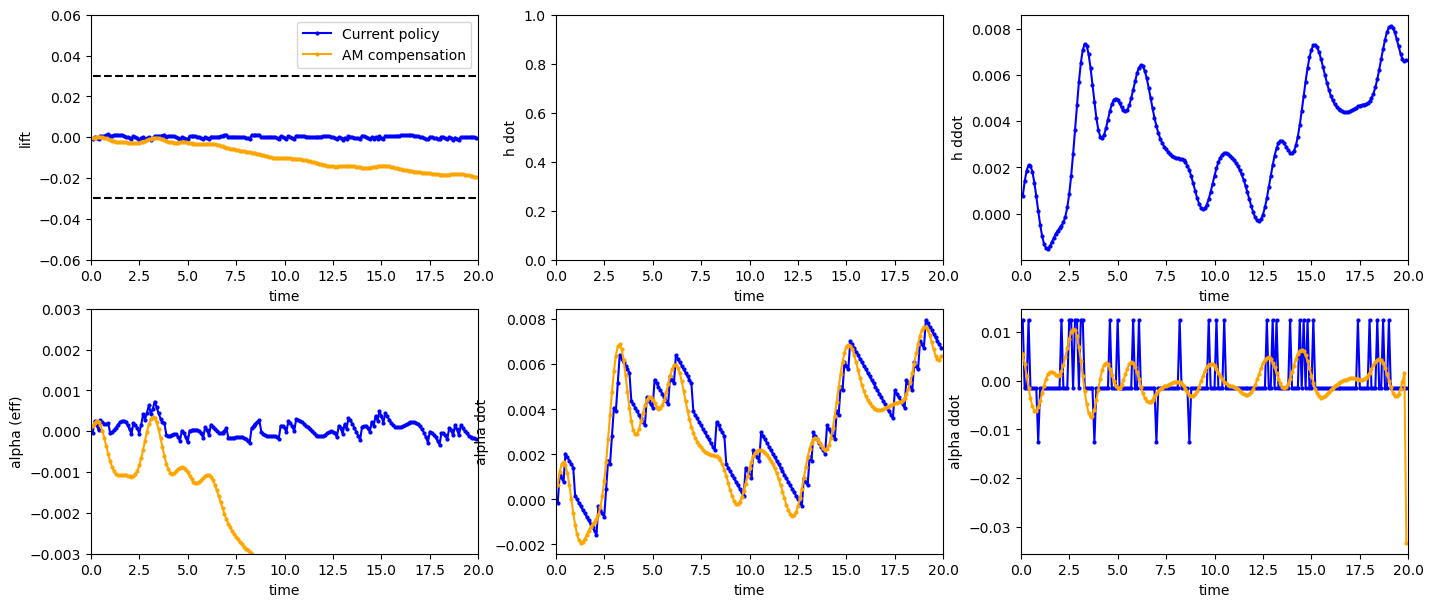

In [10]:
lift_threshold = env_discrete_mid_chord.lift_threshold
policy_color = 'blue'
am_action_color = 'orange'

figure, axarr = plt.subplots(ncols=3, nrows=2, figsize=(17,7), )
axarr[0,0].set_ylabel('lift')
axarr[0,1].set_ylabel('h dot')
axarr[0,2].set_ylabel('h ddot')
axarr[1,0].set_ylabel('alpha (eff)')
axarr[1,1].set_ylabel('alpha dot')
axarr[1,2].set_ylabel('alpha ddot')

axarr[0,0].set_ylim([-2*lift_threshold,2*lift_threshold])
axarr[0,0].plot(t[:-1],fy[1:],marker='o',markersize=2,label=f"Current policy", color=policy_color)
axarr[0,0].plot(am_action_t[:-1],am_action_fy[1:],marker='o',markersize=2,label=f"AM compensation",color=am_action_color)
axarr[0,0].hlines([-lift_threshold,lift_threshold],t[:-1][0],t[:-1][-1],linestyles='dashed',colors='black')

axarr[0,2].plot(t[:-1],h_ddot[:-1],marker='o',markersize=2, color=policy_color)

axarr[1,0].set_ylim([-0.003,0.003])
axarr[1,0].plot(t[:-1],alpha_eff[:-1],marker='o',markersize=2, color=policy_color)
axarr[1,0].plot(am_action_t[:-1],am_action_alpha_eff[:-1],marker='o',markersize=2, color=am_action_color)

axarr[1,1].plot(t[:-1],alpha_dot[:-1],marker='o',markersize=2, color=policy_color)
axarr[1,1].plot(am_action_t[:-1],am_action_alpha_dot[:-1],marker='o',markersize=2, color=am_action_color)

axarr[1,2].plot(t[:-1],alpha_ddot[1:],marker='o',markersize=2, color=policy_color)
axarr[1,2].plot(am_action_t[:-1],am_action_alpha_ddot[1:],marker='o',markersize=2, color=am_action_color)


axarr[0,0].legend()
for ax in axarr.flatten():
    ax.set_xlabel('time')
    ax.set_xlim([0.0,t_max])

## TD3

In [11]:
loaded_TD3_model = TD3.load("/u/home/b/beckers/project-sofia/unsteady_aero_RL/logs/TD3_reward_type_3_saved/TD3_1/saved_model")

In [12]:
alpha_eff = []
alpha_dot = []
alpha_ddot = []
h_ddot = []
fy = []
t = []

evaluate_policy(loaded_TD3_model, env_continuous_mid_chord, n_eval_episodes=1, callback=collect_data)

(194.89942622184753, 0.0)

In [13]:
am_action_fy = []
am_action_t = []
am_action_alpha_eff = []
am_action_alpha_dot = []
am_action_alpha_ddot = []

h_ddot_list = np.copy(h_ddot)
h_ddot_list = np.pad(h_ddot_list, (0, int(t_max / delta_t) + 1 - len(h_ddot_list)), 'constant')

am_action_env = gym.make(
    'aero_gym/wagner_jones-v0',
    render_mode="ansi",
    t_max=t_max,
    delta_t=delta_t,
    continuous_actions=True,
    lift_threshold=1)

am_action = 1 / am_action_env.alpha_ddot_threshold * np.gradient(h_ddot_list, delta_t)
am_action_env.reset(options={"h_ddot_prescribed": h_ddot_list})

done = False
i = 0
while done is False:
    action = am_action[i]
    _, _, _, done, info = am_action_env.step([action])
    am_action_fy.append(info["previous fy"])
    am_action_t.append(info["current t"])
    am_action_alpha_eff.append(info["current alpha_eff"])
    am_action_alpha_dot.append(info["current alpha_dot"])
    am_action_alpha_ddot.append(info["previous alpha_ddot"])
    i += 1

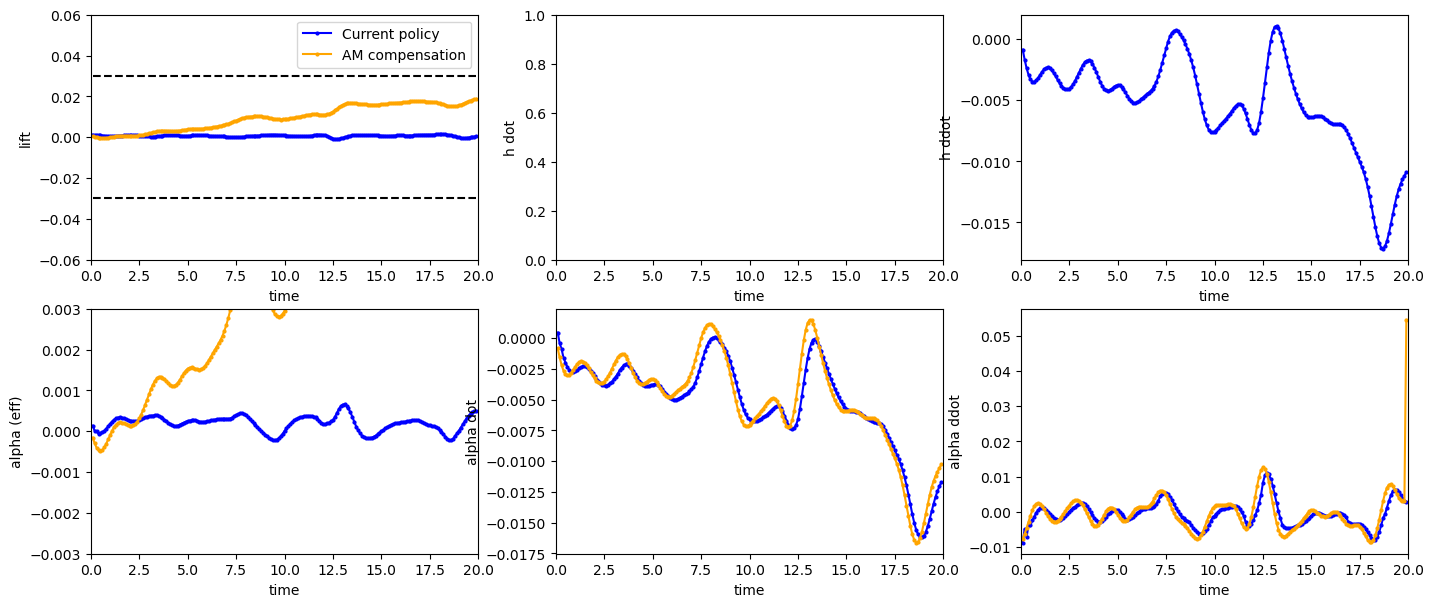

In [14]:
lift_threshold = env_discrete_mid_chord.lift_threshold
policy_color = 'blue'
am_action_color = 'orange'

figure, axarr = plt.subplots(ncols=3, nrows=2, figsize=(17,7), )
axarr[0,0].set_ylabel('lift')
axarr[0,1].set_ylabel('h dot')
axarr[0,2].set_ylabel('h ddot')
axarr[1,0].set_ylabel('alpha (eff)')
axarr[1,1].set_ylabel('alpha dot')
axarr[1,2].set_ylabel('alpha ddot')

axarr[0,0].set_ylim([-2*lift_threshold,2*lift_threshold])
axarr[0,0].plot(t[:-1],fy[1:],marker='o',markersize=2,label=f"Current policy", color=policy_color)
axarr[0,0].plot(am_action_t[:-1],am_action_fy[1:],marker='o',markersize=2,label=f"AM compensation",color=am_action_color)
axarr[0,0].hlines([-lift_threshold,lift_threshold],t[:-1][0],t[:-1][-1],linestyles='dashed',colors='black')

axarr[0,2].plot(t[:-1],h_ddot[:-1],marker='o',markersize=2, color=policy_color)

axarr[1,0].set_ylim([-0.003,0.003])
axarr[1,0].plot(t[:-1],alpha_eff[:-1],marker='o',markersize=2, color=policy_color)
axarr[1,0].plot(am_action_t[:-1],am_action_alpha_eff[:-1],marker='o',markersize=2, color=am_action_color)

axarr[1,1].plot(t[:-1],alpha_dot[:-1],marker='o',markersize=2, color=policy_color)
axarr[1,1].plot(am_action_t[:-1],am_action_alpha_dot[:-1],marker='o',markersize=2, color=am_action_color)

axarr[1,2].plot(t[:-1],alpha_ddot[1:],marker='o',markersize=2, color=policy_color)
axarr[1,2].plot(am_action_t[:-1],am_action_alpha_ddot[1:],marker='o',markersize=2, color=am_action_color)


axarr[0,0].legend()
for ax in axarr.flatten():
    ax.set_xlabel('time')
    ax.set_xlim([0.0,t_max])